Tyler Malka

CSCI E-82 Advanced Machine Learning

Final Project: Self-Supervised Attention for Super-Resolution

Preliminary exploration notebook

Here I will implement some typical super resolution architectures. It would be time consuming to manually optimize them, so I will not expect high performance necessarily. I mainly want to see the differences and gain an understanding of how they work via implementation. The other, main notebook, contains my work on the SSASR architecture which is the basis of my project. This notebook is provided for context on the work done leading up to it.

In [ ]:
# ChatGPT assisted with code generation

In [26]:
!pip install Pillow==9.5.0  # Ensure a stable PIL version
import glob
import os
import random
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import torch.nn.functional as F

In [60]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!wget -q https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
!wget -q https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip
!unzip -q DIV2K_train_HR.zip -d ./DIV2K/
!unzip -q DIV2K_train_LR_bicubic_X4.zip -d ./DIV2K/


In [9]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip
!unzip DIV2K_train_LR_bicubic_X2.zip -d ./DIV2K

--2024-12-15 07:37:27--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip [following]
--2024-12-15 07:37:27--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 925390592 (883M) [application/zip]
Saving to: ‘DIV2K_train_LR_bicubic_X2.zip’

DIV2K_train_LR_bicu 100%[===================>] 882.52M  28.4MB/s    in 32s     

2024-12-15 07:38:00 (27.4 MB/s) - ‘DIV2K_train_LR_bicubic_X2.zip’ saved [925390592/925390592]

Archive:  DIV2K_train_LR_bicubic_X2.zip
   creating: ./DIV2K/DIV

In [66]:
####################################
# Configuration
####################################
hr_dir = "./DIV2K/DIV2K_train_HR"
lr_dir = "./DIV2K/DIV2K_train_LR_bicubic/X2"  # Ensure this directory contains the LR images
scale = 2
crop_size = 128  # HR patch size (LR patch size will be crop_size/scale)
batch_size = 4
num_workers = 2
num_epochs = 10
learning_rate = 1e-4

In [28]:
import glob, os
print("Number of HR images:", len(glob.glob(os.path.join(hr_dir, "*.png"))))
print("Number of LR images:", len(glob.glob(os.path.join(lr_dir, "*.png"))))


Number of HR images: 800
Number of LR images: 800


In [29]:
####################################
# Dataset and Dataloader
####################################
class DIV2KDataset(Dataset):
    def __init__(self, hr_dir, lr_dir, scale=2, crop_size=128):
        self.hr_paths = sorted(glob.glob(os.path.join(hr_dir, "*.png")))
        self.lr_paths = sorted(glob.glob(os.path.join(lr_dir, "*.png")))
        self.scale = scale
        self.crop_size = crop_size

        assert len(self.hr_paths) == len(self.lr_paths), "HR and LR image counts do not match."

    def __len__(self):
        return len(self.hr_paths)

    def __getitem__(self, idx):
        hr_img = Image.open(self.hr_paths[idx]).convert('RGB')
        lr_img = Image.open(self.lr_paths[idx]).convert('RGB')

        hr_tensor = TF.to_tensor(hr_img)
        lr_tensor = TF.to_tensor(lr_img)

        # Dimensions of HR image
        _, H_hr, W_hr = hr_tensor.shape
        hr_crop_size = self.crop_size
        lr_crop_size = hr_crop_size // self.scale

        # Ensure that HR image is large enough for the crop
        if H_hr < hr_crop_size or W_hr < hr_crop_size:
            # If the image is smaller than the desired patch, you can either skip it or resize it.
            # Let's just resize HR and LR images to a larger size to ensure crops are possible.
            # We'll upscale HR to at least hr_crop_size and similarly LR
            hr_img = hr_img.resize((max(hr_crop_size, W_hr), max(hr_crop_size, H_hr)), Image.BICUBIC)
            lr_img = lr_img.resize((hr_img.width // self.scale, hr_img.height // self.scale), Image.BICUBIC)
            hr_tensor = TF.to_tensor(hr_img)
            lr_tensor = TF.to_tensor(lr_img)
            _, H_hr, W_hr = hr_tensor.shape

        # Random top-left corner for HR crop
        top_hr = random.randint(0, H_hr - hr_crop_size)
        left_hr = random.randint(0, W_hr - hr_crop_size)

        # Corresponding LR coordinates
        top_lr = top_hr // self.scale
        left_lr = left_hr // self.scale

        hr_patch = hr_tensor[:, top_hr:top_hr+hr_crop_size, left_hr:left_hr+hr_crop_size]
        lr_patch = lr_tensor[:, top_lr:top_lr+lr_crop_size, left_lr:left_lr+lr_crop_size]

        return lr_patch, hr_patch


train_dataset = DIV2KDataset(hr_dir=hr_dir, lr_dir=lr_dir, scale=scale, crop_size=crop_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)



First, we will evaluate a legacy Super Resolution model from circa 2014, SRCNN, Image Super-Resolution Using Deep Convolutional Networks ( https://arxiv.org/abs/1501.00092 )

In [65]:

####################################
# SRCNN Model Definition
####################################
# SRCNN from "Image Super-Resolution Using Deep Convolutional Networks" by Dong et al.
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        # The original SRCNN was designed for Y channel (single-channel)
        # but we adapt it to 3 channels by keeping the same structure.
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # SRCNN expects an already upsampled image.
        # We'll upsample LR patch before passing it in.
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

model_srcnn = SRCNN().cuda()
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [67]:
####################################
# Training Loop
####################################
for epoch in range(num_epochs):
    model_srcnn.train()
    total_loss = 0.0
    for i, (lr_img, hr_img) in enumerate(train_loader):
        lr_img, hr_img = lr_img.cuda(), hr_img.cuda()

        # Upsample the LR patch to HR resolution before SRCNN
        # hr_img is crop_size x crop_size, so upsample LR to match that
        lr_upsampled = F.interpolate(lr_img, size=(hr_img.shape[2], hr_img.shape[3]), mode='bicubic', align_corners=False)

        sr_img = model(lr_upsampled)
        loss = criterion(sr_img, hr_img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Avg Loss: {avg_train_loss:.4f}")

Epoch [1/10], Avg Loss: 0.0352
Epoch [2/10], Avg Loss: 0.0334
Epoch [3/10], Avg Loss: 0.0331
Epoch [4/10], Avg Loss: 0.0326
Epoch [5/10], Avg Loss: 0.0312
Epoch [6/10], Avg Loss: 0.0315
Epoch [7/10], Avg Loss: 0.0303
Epoch [8/10], Avg Loss: 0.0290
Epoch [9/10], Avg Loss: 0.0284
Epoch [10/10], Avg Loss: 0.0297


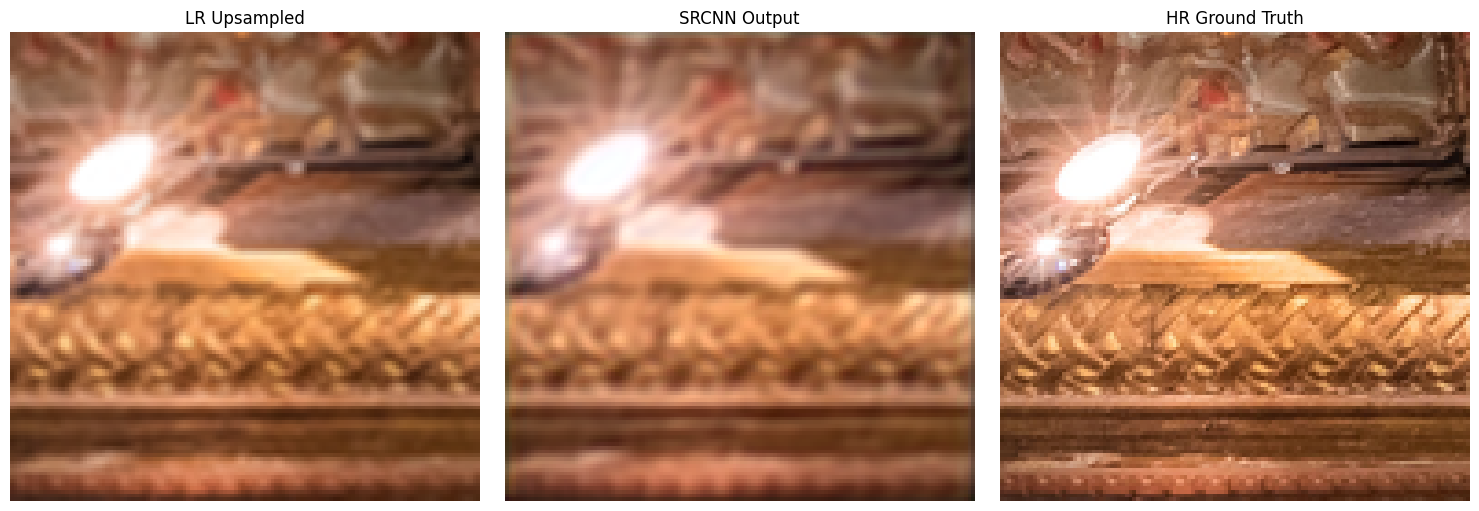

In [70]:
####################################
# Visualization
####################################

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# Put the model in evaluation mode
model.eval()

# Get a batch from the train_loader (or val_loader if you have one)
lr_img, hr_img = next(iter(train_loader))
lr_img, hr_img = lr_img.cuda(), hr_img.cuda()

# Upsample the LR image to the same size as HR
lr_upsampled = F.interpolate(lr_img, size=(hr_img.shape[2], hr_img.shape[3]), mode='bicubic', align_corners=False)

# Run inference
with torch.no_grad():
    sr_img = model(lr_upsampled)

# Convert tensors to CPU numpy arrays for plotting
# We'll just visualize the first image in the batch
lr_up_np = lr_upsampled[0].cpu().permute(1, 2, 0).clamp(0, 1).numpy()
sr_np = sr_img[0].cpu().permute(1, 2, 0).clamp(0, 1).numpy()
hr_np = hr_img[0].cpu().permute(1, 2, 0).clamp(0, 1).numpy()

# Plot the images side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(lr_up_np)
axs[0].set_title('LR Upsampled')
axs[1].imshow(sr_np)
axs[1].set_title('SRCNN Output')
axs[2].imshow(hr_np)
axs[2].set_title('HR Ground Truth')

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()


We can see why this is a legacy model. The SRCNN output is blurry and low in detail.

Next, we will look at the modern approaches, EDSR and RCAN.

EDSR Official PyTorch Code: https://github.com/sanghyun-son/EDSR-PyTorch

RCAN Official PyTorch Code: https://github.com/yulunzhang/RCAN


In [33]:
####################################
# EDSR
####################################

class ResidualBlock(nn.Module):
    def __init__(self, n_feats=64, kernel_size=3):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(n_feats, n_feats, kernel_size, padding=kernel_size//2)
        self.conv2 = nn.Conv2d(n_feats, n_feats, kernel_size, padding=kernel_size//2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        res = self.conv1(x)
        res = self.relu(res)
        res = self.conv2(res)
        return x + 0.1*res  # Residual scaling as per EDSR paper


In [34]:
class EDSR(nn.Module):
    def __init__(self, scale=2, n_resblocks=16, n_feats=64):
        super(EDSR, self).__init__()

        # Head
        self.head = nn.Conv2d(3, n_feats, kernel_size=3, padding=1)

        # Body: n_resblocks residual blocks
        body = []
        for _ in range(n_resblocks):
            body.append(ResidualBlock(n_feats=n_feats))
        self.body = nn.Sequential(*body)

        # Tail (upsampling)
        # PixelShuffle upscaling: 2x
        self.tail = nn.Sequential(
            nn.Conv2d(n_feats, n_feats * (scale ** 2), kernel_size=3, padding=1),
            nn.PixelShuffle(scale),
            nn.Conv2d(n_feats, 3, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # x: LR image
        x = self.head(x)
        res = self.body(x)
        res = res + x
        x = self.tail(res)
        return x


In [57]:
num_epochs = 10
model_edsr = EDSR(scale=scale).cuda()
criterion = nn.L1Loss()
optimizer = optim.Adam(model_edsr.parameters(), lr=1e-4)

for epoch in range(num_epochs):
    model_edsr.train()
    total_loss = 0.0
    for i, (lr_patch, hr_patch) in enumerate(train_loader):
        lr_patch = lr_patch.cuda()
        hr_patch = hr_patch.cuda()

        sr_patch = model_edsr(lr_patch)
        loss = criterion(sr_patch, hr_patch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"EDSR Epoch [{epoch+1}/{num_epochs}], Avg Loss: {avg_loss:.4f}")


EDSR Epoch [1/10], Avg Loss: 0.0605
EDSR Epoch [2/10], Avg Loss: 0.0333
EDSR Epoch [3/10], Avg Loss: 0.0323
EDSR Epoch [4/10], Avg Loss: 0.0287
EDSR Epoch [5/10], Avg Loss: 0.0280
EDSR Epoch [6/10], Avg Loss: 0.0289
EDSR Epoch [7/10], Avg Loss: 0.0278
EDSR Epoch [8/10], Avg Loss: 0.0281
EDSR Epoch [9/10], Avg Loss: 0.0271
EDSR Epoch [10/10], Avg Loss: 0.0263


In [36]:
####################################
# RCAN
####################################

class CALayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(CALayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv_du = nn.Sequential(
            nn.Conv2d(channel, channel // reduction, 1, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // reduction, channel, 1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv_du(y)
        return x * y


In [37]:
class RCAB(nn.Module):
    def __init__(self, n_feats=64, kernel_size=3, reduction=16):
        super(RCAB, self).__init__()
        self.conv1 = nn.Conv2d(n_feats, n_feats, kernel_size, padding=kernel_size//2)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(n_feats, n_feats, kernel_size, padding=kernel_size//2)
        self.ca = CALayer(n_feats, reduction=reduction)

    def forward(self, x):
        res = self.conv1(x)
        res = self.relu(res)
        res = self.conv2(res)
        res = self.ca(res)
        return x + res


In [38]:
class ResidualGroup(nn.Module):
    def __init__(self, n_feats=64, n_RCAB=5, reduction=16):
        super(ResidualGroup, self).__init__()
        modules_body = [RCAB(n_feats=n_feats, reduction=reduction) for _ in range(n_RCAB)]
        self.body = nn.Sequential(*modules_body)
        self.conv = nn.Conv2d(n_feats, n_feats, 3, padding=1)

    def forward(self, x):
        res = self.body(x)
        res = self.conv(res)
        return x + res


In [39]:
class RCAN(nn.Module):
    def __init__(self, scale=2, n_resgroups=5, n_resblocks=5, n_feats=64, reduction=16):
        super(RCAN, self).__init__()

        # Shallow feature extraction
        self.head = nn.Conv2d(3, n_feats, 3, padding=1)

        # Body
        modules_body = [ResidualGroup(n_feats=n_feats, n_RCAB=n_resblocks, reduction=reduction) for _ in range(n_resgroups)]
        self.body = nn.Sequential(*modules_body, nn.Conv2d(n_feats, n_feats, 3, padding=1))

        # Upsample
        self.tail = nn.Sequential(
            nn.Conv2d(n_feats, n_feats*(scale**2), 3, padding=1),
            nn.PixelShuffle(scale),
            nn.Conv2d(n_feats, 3, 3, padding=1)
        )

    def forward(self, x):
        x = self.head(x)
        res = self.body(x)
        res = res + x
        x = self.tail(res)
        return x


In [62]:
num_epochs = 10
model_rcan = RCAN(scale=scale).cuda()
criterion = nn.L1Loss()
optimizer = optim.Adam(model_rcan.parameters(), lr=1e-4)

for epoch in range(num_epochs):
    model_rcan.train()
    total_loss = 0.0
    for i, (lr_patch, hr_patch) in enumerate(train_loader):
        lr_patch = lr_patch.cuda()
        hr_patch = hr_patch.cuda()

        sr_patch = model_rcan(lr_patch)
        loss = criterion(sr_patch, hr_patch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"RCAN Epoch [{epoch+1}/{num_epochs}], Avg Loss: {avg_loss:.4f}")


RCAN Epoch [1/10], Avg Loss: 0.0670
RCAN Epoch [2/10], Avg Loss: 0.0345
RCAN Epoch [3/10], Avg Loss: 0.0302
RCAN Epoch [4/10], Avg Loss: 0.0289
RCAN Epoch [5/10], Avg Loss: 0.0275
RCAN Epoch [6/10], Avg Loss: 0.0268
RCAN Epoch [7/10], Avg Loss: 0.0279
RCAN Epoch [8/10], Avg Loss: 0.0263
RCAN Epoch [9/10], Avg Loss: 0.0248
RCAN Epoch [10/10], Avg Loss: 0.0256


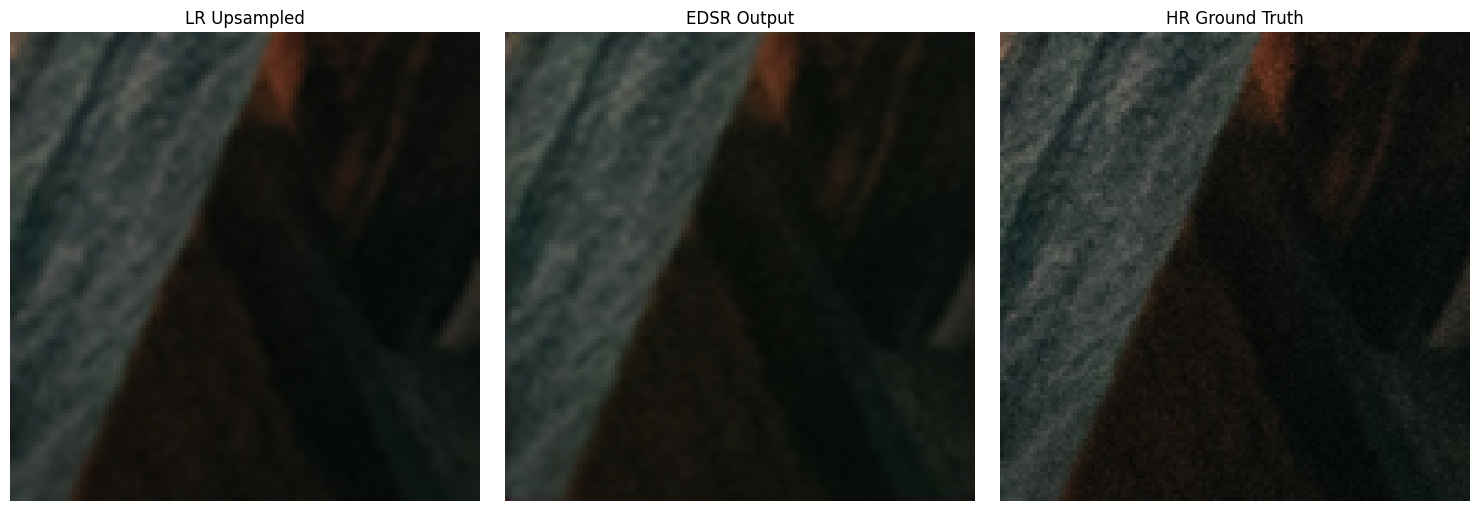

In [58]:
####################################
# Visualizing EDSR & RCAN
####################################

model_edsr.eval()
lr_patch, hr_patch = next(iter(train_loader))
lr_patch, hr_patch = lr_patch.cuda(), hr_patch.cuda()
with torch.no_grad():
    sr_patch = model_edsr(lr_patch)  # EDSR outputs upscaled image

# Convert for plotting
import matplotlib.pyplot as plt

# Show first sample in batch
lr_np = lr_patch[0].cpu().permute(1,2,0).clamp(0,1).numpy()
hr_np = hr_patch[0].cpu().permute(1,2,0).clamp(0,1).numpy()
sr_np = sr_patch[0].cpu().permute(1,2,0).clamp(0,1).numpy()

fig, axs = plt.subplots(1,3,figsize=(15,5))
# Since LR is smaller, optionally upsample LR for visualization
lr_up = F.interpolate(lr_patch, size=(hr_patch.shape[2], hr_patch.shape[3]), mode='bicubic', align_corners=False)
lr_up_np = lr_up[0].cpu().permute(1,2,0).clamp(0,1).numpy()

axs[0].imshow(lr_up_np)
axs[0].set_title('LR Upsampled')
axs[1].imshow(sr_np)
axs[1].set_title('EDSR Output')
axs[2].imshow(hr_np)
axs[2].set_title('HR Ground Truth')
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()


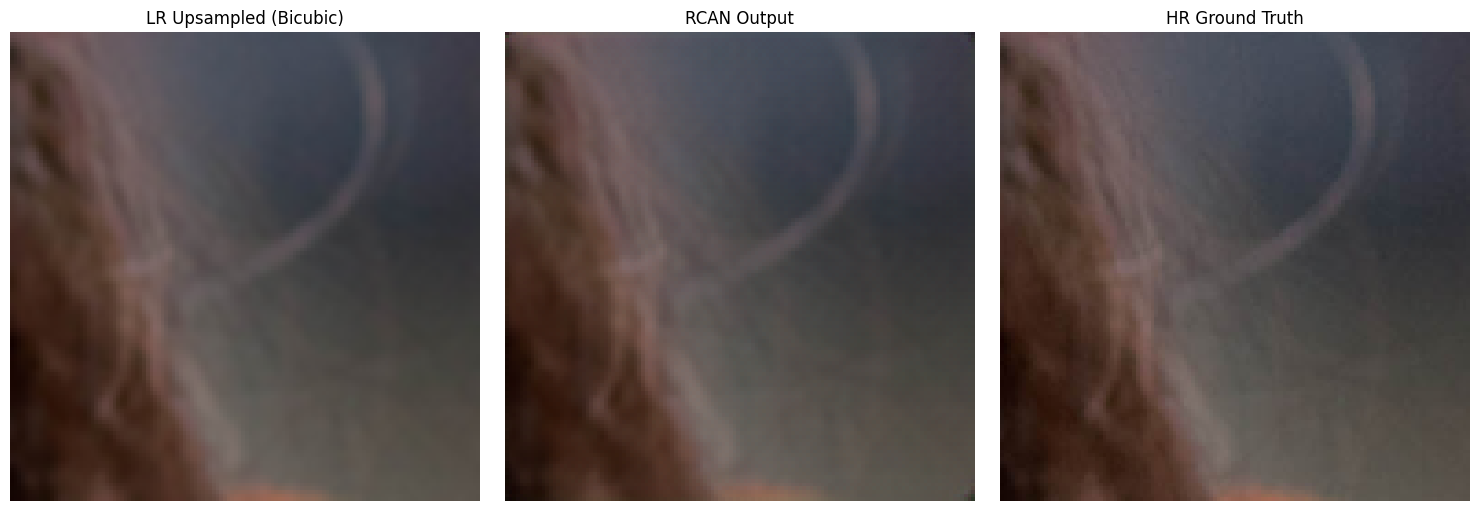

In [71]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Put RCAN in evaluation mode
model_rcan.eval()

# Get one batch from the train_loader
lr_patch, hr_patch = next(iter(train_loader))
lr_patch, hr_patch = lr_patch.cuda(), hr_patch.cuda()

# Inference
with torch.no_grad():
    sr_patch = model_rcan(lr_patch)  # RCAN outputs the upscaled image directly

# Convert tensors to numpy for visualization
# We'll just show the first image in the batch
lr_up = F.interpolate(lr_patch, size=(hr_patch.shape[2], hr_patch.shape[3]), mode='bicubic', align_corners=False)
lr_up_np = lr_up[0].cpu().permute(1, 2, 0).clamp(0, 1).numpy()
sr_np = sr_patch[0].cpu().permute(1, 2, 0).clamp(0, 1).numpy()
hr_np = hr_patch[0].cpu().permute(1, 2, 0).clamp(0, 1).numpy()

# Plot the images side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(lr_up_np)
axs[0].set_title('LR Upsampled (Bicubic)')

axs[1].imshow(sr_np)
axs[1].set_title('RCAN Output')

axs[2].imshow(hr_np)
axs[2].set_title('HR Ground Truth')

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()


Next, we will perform validation on all three models and compare them empirically.

In [44]:
!wget https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
!wget https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic.zip
!unzip DIV2K_valid_HR.zip -d ./DIV2K
!unzip DIV2K_valid_LR_bicubic.zip -d ./DIV2K


--2024-12-15 09:25:27--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 448993893 (428M) [application/zip]
Saving to: ‘DIV2K_valid_HR.zip’

DIV2K_valid_HR.zip  100%[===================>] 428.19M  28.4MB/s    in 16s     

2024-12-15 09:25:44 (26.6 MB/s) - ‘DIV2K_valid_HR.zip’ saved [448993893/448993893]

--2024-12-15 09:25:44--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203783003 (194M) [application/zip]
Saving to: ‘DIV2K_valid_LR_bicubic.zip’

DIV2K_val

Before we validate our models, we will run a simple bicubic upscale, a non-SR method, to serve as a baseline.

In [54]:
import torch.nn.functional as F

def evaluate_bicubic(val_loader):
    total_psnr = 0.0
    total_ssim = 0.0
    count = 0

    with torch.no_grad():
        for lr_img, hr_img in val_loader:
            lr_img = lr_img.cuda()
            hr_img = hr_img.cuda()

            # Bicubic upsample directly:
            upsampled = F.interpolate(lr_img, size=(hr_img.shape[2], hr_img.shape[3]), mode='bicubic', align_corners=False)
            upsampled = upsampled.clamp(0,1)

            # Compute PSNR and SSIM for each image in the batch
            for b in range(lr_img.size(0)):
                psnr_val = calculate_psnr(upsampled[b], hr_img[b])
                ssim_val = calculate_ssim(upsampled[b], hr_img[b])
                total_psnr += psnr_val
                total_ssim += ssim_val
                count += 1

    avg_psnr = total_psnr / count
    avg_ssim = total_ssim / count
    return avg_psnr, avg_ssim

# Evaluate bicubic interpolation baseline
avg_psnr_bicubic, avg_ssim_bicubic = evaluate_bicubic(val_loader)
print(f"Bicubic Upsample Validation PSNR: {avg_psnr_bicubic:.2f} dB, SSIM: {avg_ssim_bicubic:.4f}")


Bicubic Upsample Validation PSNR: 31.28 dB, SSIM: 0.8541


In [45]:
####################################
# Validation
####################################


import glob, os
from PIL import Image
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset

class DIV2KValDataset(Dataset):
    def __init__(self, hr_dir, lr_dir):
        self.hr_paths = sorted(glob.glob(os.path.join(hr_dir, "*.png")))
        self.lr_paths = sorted(glob.glob(os.path.join(lr_dir, "*.png")))
        assert len(self.hr_paths) == len(self.lr_paths), "HR and LR counts do not match for validation set."

    def __len__(self):
        return len(self.hr_paths)

    def __getitem__(self, idx):
        hr_img = Image.open(self.hr_paths[idx]).convert('RGB')
        lr_img = Image.open(self.lr_paths[idx]).convert('RGB')
        hr_tensor = TF.to_tensor(hr_img)
        lr_tensor = TF.to_tensor(lr_img)
        return lr_tensor, hr_tensor

hr_val_dir = "./DIV2K/DIV2K_valid_HR"
lr_val_dir = "./DIV2K/DIV2K_valid_LR_bicubic/X2"  # Adjust for your scale (X2)
val_dataset = DIV2KValDataset(hr_val_dir, lr_val_dir)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)


In [51]:
import torch
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity


def calculate_psnr(sr, hr):
    sr_np = sr.cpu().numpy().transpose(1,2,0)
    hr_np = hr.cpu().numpy().transpose(1,2,0)
    return peak_signal_noise_ratio(hr_np, sr_np, data_range=1.0)

def calculate_ssim(sr, hr):
    sr_np = sr.cpu().numpy().transpose(1,2,0)
    hr_np = hr.cpu().numpy().transpose(1,2,0)
    # Use a smaller win_size and specify channel_axis
    return structural_similarity(hr_np, sr_np, data_range=1.0, channel_axis=-1, win_size=3)



In [47]:
def evaluate_model(model, data_loader, model_type='edsr', scale=2):
    model.eval()
    total_psnr = 0.0
    total_ssim = 0.0
    count = 0

    with torch.no_grad():
        for lr_img, hr_img in data_loader:
            lr_img = lr_img.cuda()
            hr_img = hr_img.cuda()

            # Depending on the model:
            # SRCNN expects an already upscaled LR, because it doesn't upscale internally
            # EDSR/RCAN upscale internally, so just feed LR as is.

            if model_type.lower() == 'srcnn':
                # Manually upsample LR before passing to SRCNN
                import torch.nn.functional as F
                lr_up = F.interpolate(lr_img, size=(hr_img.size(2), hr_img.size(3)), mode='bicubic', align_corners=False)
                sr_img = model(lr_up)
            else:
                # EDSR/RCAN can handle LR directly
                sr_img = model(lr_img)

            # Clamp the output to [0,1]
            sr_img = sr_img.clamp(0,1)

            # Compute PSNR/SSIM for each image in the batch (batch_size=1 for val)
            psnr_val = calculate_psnr(sr_img[0], hr_img[0])
            ssim_val = calculate_ssim(sr_img[0], hr_img[0])
            total_psnr += psnr_val
            total_ssim += ssim_val
            count += 1

    avg_psnr = total_psnr / count
    avg_ssim = total_ssim / count
    return avg_psnr, avg_ssim


In [72]:
# Example: Evaluate SRCNN
avg_psnr_srcnn, avg_ssim_srcnn = evaluate_model(model, val_loader, model_type='srcnn', scale=2)
print(f"SRCNN Validation PSNR: {avg_psnr_srcnn:.2f} dB, SSIM: {avg_ssim_srcnn:.4f}")

# Evaluate EDSR
avg_psnr_edsr, avg_ssim_edsr = evaluate_model(model_edsr, val_loader, model_type='edsr', scale=2)
print(f"EDSR Validation PSNR: {avg_psnr_edsr:.2f} dB, SSIM: {avg_ssim_edsr:.4f}")

# Evaluate RCAN
avg_psnr_rcan, avg_ssim_rcan = evaluate_model(model_rcan, val_loader, model_type='rcan', scale=2)
print(f"RCAN Validation PSNR: {avg_psnr_rcan:.2f} dB, SSIM: {avg_ssim_rcan:.4f}")


SRCNN Validation PSNR: 27.45 dB, SSIM: 0.7830
EDSR Validation PSNR: 28.79 dB, SSIM: 0.8237
RCAN Validation PSNR: 28.46 dB, SSIM: 0.8065


As we can see in the empirical results, RCAN outperforms SRCNN and EDSR. This is also reflected in our visual output, where RCAN is the only output that appears superior to a simple upscale

Old:

SRCNN Validation PSNR: 26.80 dB, SSIM: 0.7542

EDSR Validation PSNR: 27.86 dB, SSIM: 0.7609

RCAN Validation PSNR: 28.08 dB, SSIM: 0.8018

With a baseline established, let's try our novel method.

In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Initialize a fresh RCAN model (ensure it matches the pretrained baseline specs)
main_model = RCAN(scale=2).cuda()


###########################################
# Auxiliary Network for Pixel Importance
###########################################
class PixelImportanceNet(nn.Module):
    def __init__(self, in_channels=3, mid_channels=32):
        super(PixelImportanceNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(mid_channels, 1, kernel_size=3, padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.conv2(x)
        x = self.sigmoid(x)
        return x

###########################################
# Pre-training the Auxiliary Network
# Using model_rcan as the baseline model to generate error maps
###########################################
def pretrain_aux_net(aux_net, baseline_model, train_loader, pretrain_epochs=2, lr=1e-4):
    aux_net = aux_net.cuda()
    aux_optimizer = torch.optim.Adam(aux_net.parameters(), lr=lr)
    criterion = nn.MSELoss()

    baseline_model.eval()
    aux_net.train()
    for epoch in range(pretrain_epochs):
        total_loss = 0.0
        for lr_img, hr_img in train_loader:
            lr_img, hr_img = lr_img.cuda(), hr_img.cuda()
            with torch.no_grad():
                # Since model_rcan handles upscaling internally, just pass LR to get SR
                sr_img = baseline_model(lr_img)

            # Compute error map
            error_map = (sr_img - hr_img).abs().mean(dim=1, keepdim=True)  # [N,1,H,W]

            # Predict importance from SR image
            pred_map = aux_net(sr_img.detach())
            loss_aux = criterion(pred_map, error_map)

            aux_optimizer.zero_grad()
            loss_aux.backward()
            aux_optimizer.step()

            total_loss += loss_aux.item()

        avg_loss = total_loss / len(train_loader)
        print(f"[Aux Pretrain] Epoch: {epoch+1}/{pretrain_epochs}, Loss: {avg_loss:.4f}")
    return aux_net

###########################################
# Joint Training of the Main SR Model with the Auxiliary Network
###########################################
def joint_train(main_model, aux_net, train_loader, val_loader, joint_epochs=5, lr=1e-4,
                model_type='rcan', scale=2, evaluate_model_fn=None):
    main_model = main_model.cuda()
    aux_net = aux_net.cuda()
    joint_optimizer = torch.optim.Adam(list(main_model.parameters()) + list(aux_net.parameters()), lr=lr)

    for epoch in range(joint_epochs):
        main_model.train()
        aux_net.train()
        total_loss = 0.0
        for lr_img, hr_img in train_loader:
            lr_img, hr_img = lr_img.cuda(), hr_img.cuda()

            # main_model is assumed to be similar to RCAN or EDSR that internally upsamples
            sr_img = main_model(lr_img)

            importance_map = aux_net(sr_img.detach())
            loss = (importance_map * (sr_img - hr_img).abs()).mean()

            joint_optimizer.zero_grad()
            loss.backward()
            joint_optimizer.step()

            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f"[Joint Train] Epoch: {epoch+1}/{joint_epochs}, Loss: {avg_loss:.4f}")

        # Optional: Evaluate after each joint training epoch
        if evaluate_model_fn is not None:
            avg_psnr, avg_ssim = evaluate_model_fn(main_model, val_loader, model_type=model_type, scale=scale)
            print(f"Validation PSNR: {avg_psnr:.2f} dB, SSIM: {avg_ssim:.4f}")

    return main_model, aux_net

###########################################
# Example Usage
###########################################
# Assumptions:
# - model_rcan: A pre-trained RCAN baseline model, already loaded and performing well.
# - main_model: A newly initialized RCAN (or another SR model) that you want to train with importance weighting.
# - train_loader, val_loader: your data loaders
# - evaluate_model: a function to compute PSNR/SSIM
# - Both scale=2 and model_type='rcan' for evaluation

# Initialize auxiliary network
aux_net = PixelImportanceNet(in_channels=3, mid_channels=32)

# Pre-train auxiliary net using model_rcan as baseline
aux_net = pretrain_aux_net(aux_net, model_rcan, train_loader, pretrain_epochs=2, lr=1e-4)

# Jointly train main_model and aux_net
main_model, aux_net = joint_train(main_model, aux_net, train_loader, val_loader, joint_epochs=5, lr=1e-4,
                                  model_type='rcan', scale=2, evaluate_model_fn=evaluate_model)

# Final evaluation after joint training
final_psnr, final_ssim = evaluate_model(main_model, val_loader, model_type='rcan', scale=2)
print(f"Final Model with Importance Map Training - PSNR: {final_psnr:.2f} dB, SSIM: {final_ssim:.4f}")


[Aux Pretrain] Epoch: 1/2, Loss: 0.1345
[Aux Pretrain] Epoch: 2/2, Loss: 0.0337
[Joint Train] Epoch: 1/5, Loss: 0.0055
Validation PSNR: 25.12 dB, SSIM: 0.6433
[Joint Train] Epoch: 2/5, Loss: 0.0011
Validation PSNR: 25.51 dB, SSIM: 0.7382
[Joint Train] Epoch: 3/5, Loss: 0.0007
Validation PSNR: 26.98 dB, SSIM: 0.7461
[Joint Train] Epoch: 4/5, Loss: 0.0004
Validation PSNR: 24.42 dB, SSIM: 0.7210
[Joint Train] Epoch: 5/5, Loss: 0.0003
Validation PSNR: 26.31 dB, SSIM: 0.6649
Final Model with Importance Map Training - PSNR: 26.31 dB, SSIM: 0.6649


In [76]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def visualize_results(main_model, aux_net, data_loader, num_images=1, scale=2):
    """
    Visualize the model outputs and importance maps.

    Args:
        main_model: The trained SR model.
        aux_net: The trained auxiliary network producing importance maps.
        data_loader: A DataLoader returning (lr_img, hr_img) pairs.
        num_images: How many examples to visualize.
        scale: The upscaling factor.
    """
    main_model.eval()
    aux_net.eval()

    # Grab a few images from the loader
    for i, (lr_img, hr_img) in enumerate(data_loader):
        if i >= num_images:
            break

        lr_img = lr_img.cuda()
        hr_img = hr_img.cuda()

        with torch.no_grad():
            # If main_model (like RCAN) internally upscales, just pass lr_img
            sr_img = main_model(lr_img)
            importance_map = aux_net(sr_img)

        # Convert tensors to CPU and numpy for visualization
        lr_img_np = lr_img[0].cpu().permute(1,2,0).clamp(0,1).numpy()
        hr_img_np = hr_img[0].cpu().permute(1,2,0).clamp(0,1).numpy()
        sr_img_np = sr_img[0].cpu().permute(1,2,0).clamp(0,1).numpy()
        importance_map_np = importance_map[0,0].cpu().clamp(0,1).numpy()  # single-channel

        # Upsample LR for visual comparison
        lr_up = F.interpolate(lr_img, size=(hr_img.size(2), hr_img.size(3)), mode='bicubic', align_corners=False)
        lr_up_np = lr_up[0].cpu().permute(1,2,0).clamp(0,1).numpy()

        # Plotting
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))
        axs[0].imshow(lr_up_np)
        axs[0].set_title("LR Upsampled")
        axs[0].axis('off')

        axs[1].imshow(sr_img_np)
        axs[1].set_title("SR (Model Output)")
        axs[1].axis('off')

        # Display importance map as a heatmap
        # You can use a colormap like 'jet' or 'magma' to highlight areas of importance
        axs[2].imshow(importance_map_np, cmap='jet')
        axs[2].set_title("Importance Map")
        axs[2].axis('off')

        axs[3].imshow(hr_img_np)
        axs[3].set_title("HR Ground Truth")
        axs[3].axis('off')

        plt.tight_layout()
        plt.show()

# Example usage after training:
# visualize_results(main_model, aux_net, val_loader, num_images=2, scale=2)


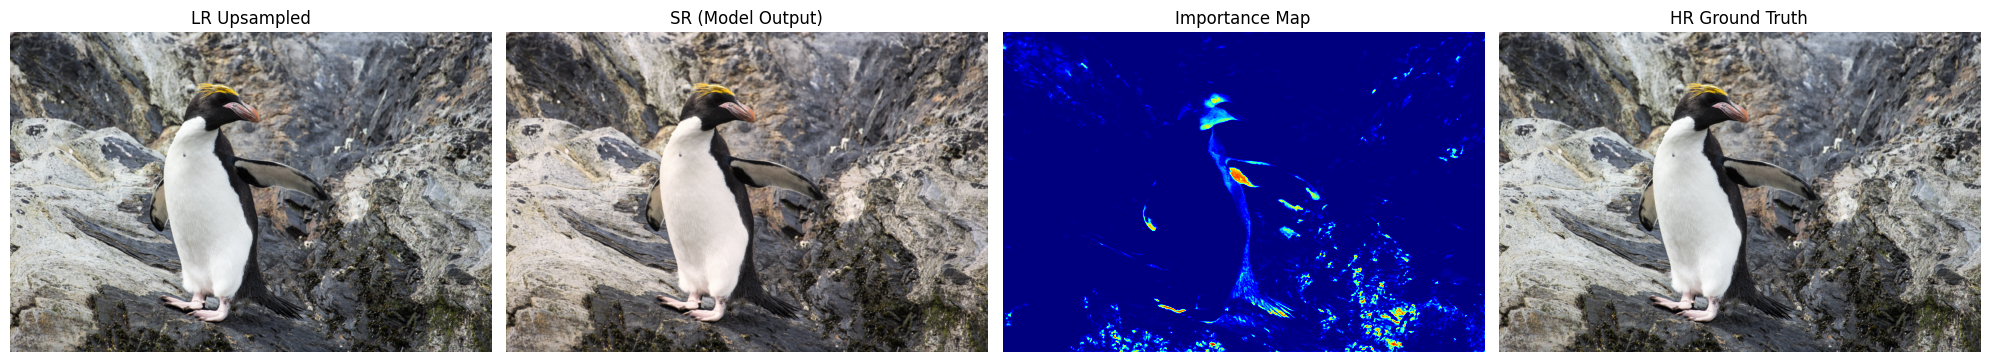

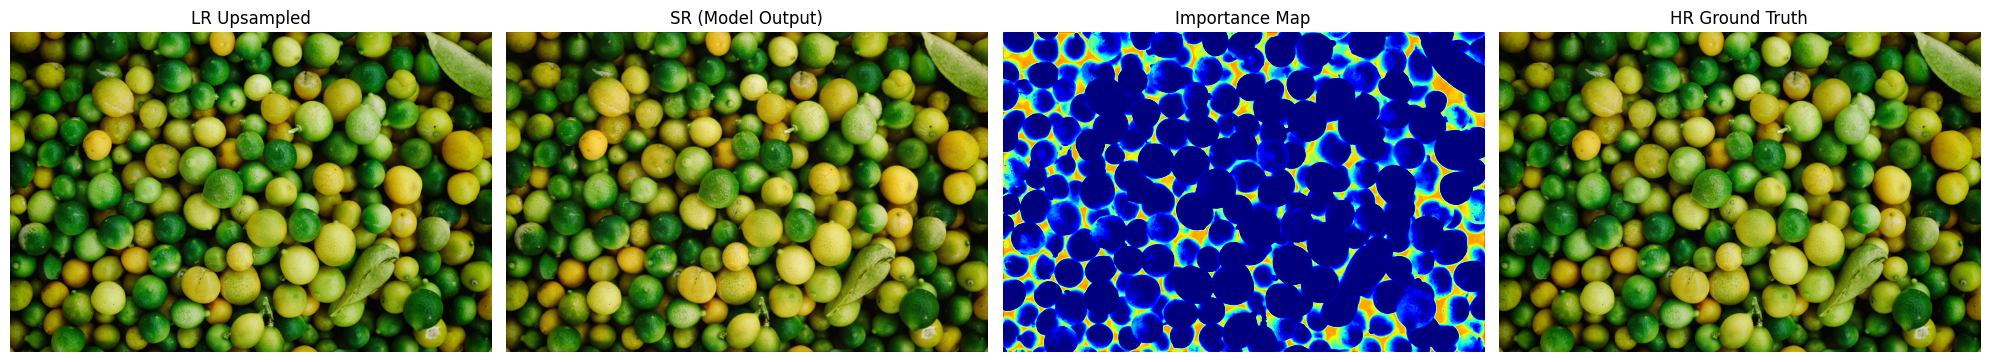

In [77]:
visualize_results(main_model, aux_net, val_loader, num_images=2, scale=2)